## Robot Path Planning using Potential Field Method

### Task:

<p>Write a program for planning a path from the initial point to the final point bypassing obstacles using the potential field method. You have to determine the initial point of movement, the final point, and obstacles in the workspace. The program code must reflect all the steps for constructing the potential field of the workspace, the order of calculating the gradient, and determining the subsequent direction of movement.</p>

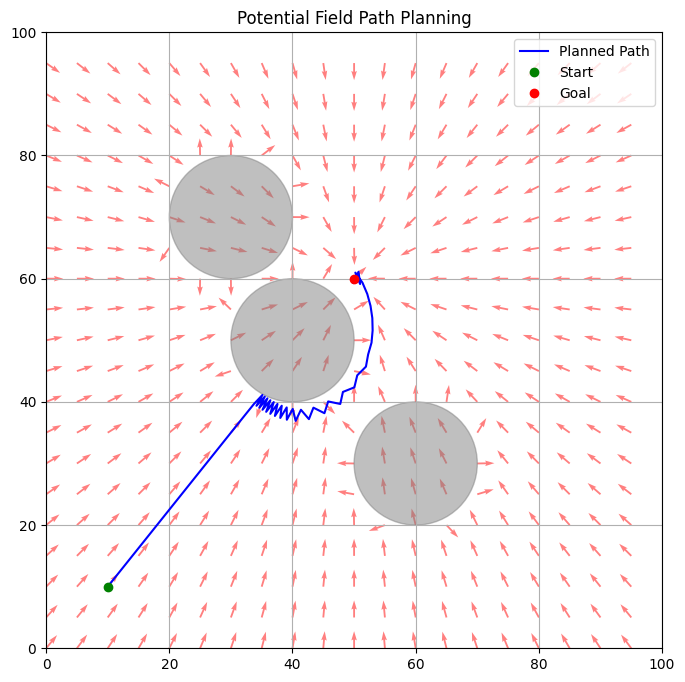

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
grid_size = (100, 100)
start = np.array([10, 10])
goal = np.array([50, 60]) #np.array([50, 70])
obstacles = [np.array([40, 50]), np.array([60, 30]), np.array([30, 70])]
obstacle_radius = 10

# Potential field parameters
k_att = 1.0    # Attractive gain
k_rep = 100.0  # Repulsive gain
repulsive_threshold = 20.0


def attractive_potential(pos, goal):
    """
    Computes the attractive potential at a given position.

    Args:
        pos (np.array): Current position.
        goal (np.array): Goal position.

    Returns:
        float: Attractive potential value.
    """
    return 0.5 * k_att * np.linalg.norm(pos - goal)**2


# def repulsive_potential(pos, obstacles):
#     U_rep = 0
#     for obs in obstacles:
#         d = np.linalg.norm(pos - obs)
#         if d <= repulsive_threshold:
#             U_rep += 0.5 * k_rep * (1.0 / d - 1.0 / repulsive_threshold)**2
#     return U_rep

def repulsive_potential(pos, obstacles):
    """
    Computes the repulsive potential at a given position due to all obstacles.

    Args:
        pos (np.array): Current position.
        obstacles (list of np.array): List of obstacle positions.

    Returns:
        float: Repulsive potential value.
    """
    U_rep = 0
    for obs in obstacles:
        d = max(1e-4, np.linalg.norm(pos - obs) - obstacle_radius)
        if d <= repulsive_threshold:
            U_rep += 0.5 * k_rep * (1.0 / d - 1.0 / repulsive_threshold)**2
    return U_rep


def total_potential(pos, goal, obstacles):
    """
    Computes the total potential (attractive + repulsive) at a given position.

    Args:
        pos (np.array): Current position.
        goal (np.array): Goal position.
        obstacles (list of np.array): List of obstacle positions.

    Returns:
        float: Total potential value.
    """
    return attractive_potential(pos, goal) + repulsive_potential(pos, obstacles)

def compute_gradient(pos, goal, obstacles, epsilon=1e-4):
    """
    Numerically estimates the gradient of the total potential field at a given position.
    Method Used: central difference method, a finite difference approximation for 
                 computing gradients (numerical derivatives).

    Args:
        pos (np.array): Current position.
        goal (np.array): Goal position.
        obstacles (list of np.array): List of obstacle positions.
        epsilon (float): Small value for numerical differentiation.

    Returns:
        np.array: Gradient vector at the position.
    """
    grad = np.zeros(2)
    for i in range(2):
        delta = np.zeros(2)
        delta[i] = epsilon
        U_plus = total_potential(pos + delta, goal, obstacles)
        U_minus = total_potential(pos - delta, goal, obstacles)
        grad[i] = (U_plus - U_minus) / (2 * epsilon)
    return grad


def plan_path(start, goal, obstacles):
    """
    Plans a path from start to goal using gradient descent on the potential field.

    Args:
        start (np.array): Starting position.
        goal (np.array): Goal position.
        obstacles (list of np.array): List of obstacle positions.

    Returns:
        np.array: List of positions representing the planned path.
    """
    path = [start.copy()]
    current = start.copy()
    max_steps = 1000
    step_size = 2

    for _ in range(max_steps):
        grad = compute_gradient(current, goal, obstacles)
        norm = np.linalg.norm(grad)
        if norm < 1e-2:
            break
        direction = -grad / norm
        current = current + step_size * direction
        path.append(current.copy())
        if np.linalg.norm(current - goal) < 1.0:
            break
    return np.array(path)

def compute_gradient_field(grid_size, goal, obstacles, step=5):
    """
    Computes the gradient field over a grid for visualization.

    Args:
        grid_size (tuple): Size of the grid (width, height).
        goal (np.array): Goal position.
        obstacles (list of np.array): List of obstacle positions.
        step (int): Step size between grid points.

    Returns:
        tuple: Meshgrid arrays (X, Y) and gradient vectors (U, V).
    """
    X, Y = np.meshgrid(np.arange(0, grid_size[0], step), np.arange(0, grid_size[1], step))
    U = np.zeros_like(X, dtype=np.float32)
    V = np.zeros_like(Y, dtype=np.float32)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            pos = np.array([X[i, j], Y[i, j]])
            grad = compute_gradient(pos, goal, obstacles)
            norm = np.linalg.norm(grad)
            if norm != 0:
                grad /= norm
            U[i, j] = -grad[0]  # Negative gradient = direction of steepest descent
            V[i, j] = -grad[1]
    return X, Y, U, V

# Plot gradient map
X, Y, U, V = compute_gradient_field(grid_size, goal, obstacles)

# Generate the path
path = plan_path(start, goal, obstacles)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.quiver(X, Y, U, V, color='r', alpha=0.5)
ax.plot(path[:, 0], path[:, 1], 'b-', label='Planned Path')
ax.plot(start[0], start[1], 'go', label='Start')
ax.plot(goal[0], goal[1], 'ro', label='Goal')
for obs in obstacles:
    circle = plt.Circle(obs, obstacle_radius, color='gray', alpha=0.5)
    ax.add_artist(circle)

ax.set_xlim(0, grid_size[0])
ax.set_ylim(0, grid_size[1])
ax.set_aspect('equal')
ax.set_title('Potential Field Path Planning')
ax.legend()
plt.grid(True)
plt.show()

In [2]:
from mpl_toolkits.mplot3d import Axes3D  # Necessary for 3D plotting

def plot_potential_field(grid_size, goal, obstacles):
    x = np.linspace(0, grid_size[0], 100)
    y = np.linspace(0, grid_size[1], 100)
    X, Y = np.meshgrid(x, y)

    Z_att = np.zeros_like(X)
    Z_rep = np.zeros_like(X)
    Z_total = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            pos = np.array([X[i, j], Y[i, j]])
            Z_att[i, j] = attractive_potential(pos, goal)
            Z_rep[i, j] = repulsive_potential(pos, obstacles)
            Z_total[i, j] = Z_att[i, j] + Z_rep[i, j]

    fig = plt.figure(figsize=(18, 5))

    # Attractive Potential
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, Y, Z_att, cmap='viridis')
    ax1.set_title('Attractive Potential')

    # Total Potential (Attractive + Repulsive)
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, Y, Z_total, cmap='viridis')
    ax2.set_title('Total Potential (Att + Rep)')

    # Repulsive Potential Only
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot_surface(X, Y, Z_rep, cmap='viridis')
    ax3.set_title('Repulsive Potential')

    plt.tight_layout()
    plt.show()


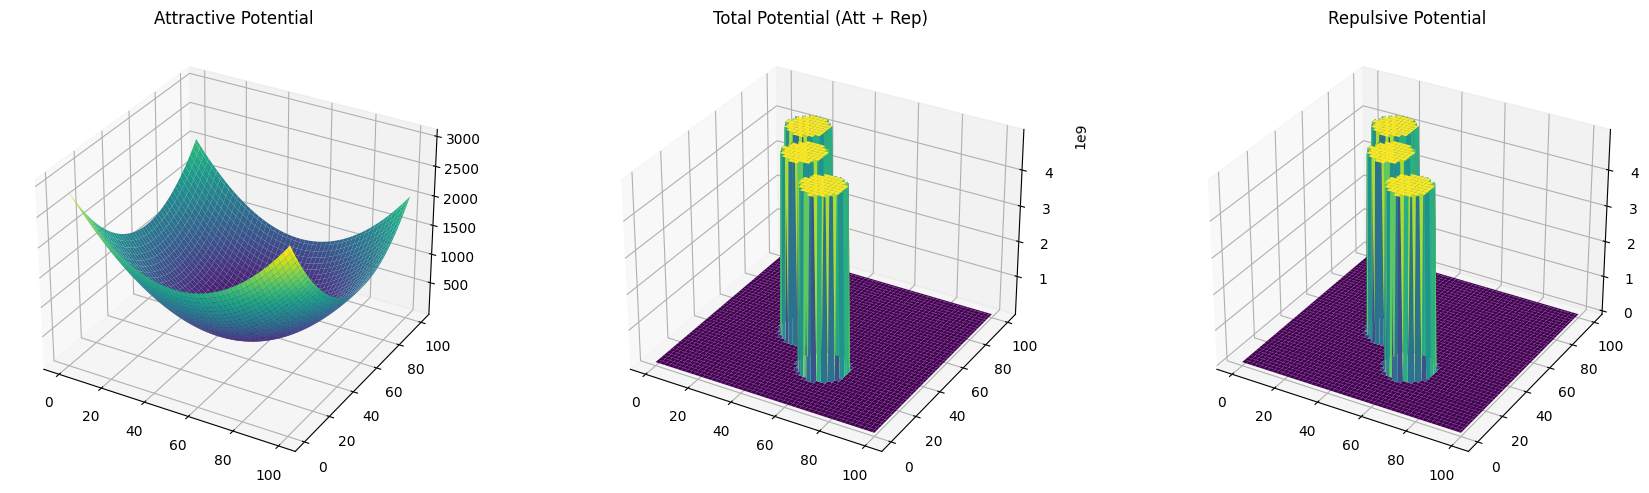

In [16]:
plot_potential_field(grid_size, goal, obstacles)

In [19]:
def plot_full_potential_map(grid_size, start, goal, obstacles, path):
    # Create mesh grid
    x = np.linspace(0, grid_size[0], 100)
    y = np.linspace(0, grid_size[1], 100)
    X, Y = np.meshgrid(x, y)

    Z_att = np.zeros_like(X)
    Z_rep = np.zeros_like(X)
    Z_total = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            pos = np.array([X[i, j], Y[i, j]])
            Z_att[i, j] = attractive_potential(pos, goal)
            Z_rep[i, j] = repulsive_potential(pos, obstacles)
            Z_total[i, j] = Z_att[i, j] + Z_rep[i, j]

    fig = plt.figure(figsize=(18, 10))

    # Obstacle map (binary style)
    ax0 = fig.add_subplot(231)
    ax0.set_title('Obstacle Map')
    ax0.set_xlim(0, grid_size[0])
    ax0.set_ylim(0, grid_size[1])
    ax0.set_aspect('equal')
    for obs in obstacles:
        circle = plt.Circle(obs, obstacle_radius, color='black')
        ax0.add_patch(circle)
    ax0.plot(start[0], start[1], 'go')  # start
    ax0.plot(goal[0], goal[1], 'ro')    # goal

    # Attractive potential surface
    ax1 = fig.add_subplot(232, projection='3d')
    ax1.plot_surface(X, Y, Z_att, cmap='jet', edgecolor='none')
    ax1.set_title('Attractive Potential')

    # Repulsive potential surface
    ax2 = fig.add_subplot(233, projection='3d')
    ax2.plot_surface(X, Y, Z_rep, cmap='jet', edgecolor='none')
    ax2.set_title('Repulsive Potential')

    # Total potential surface (with both attractive and repulsive parts)
#     ax3 = fig.add_subplot(234, projection='3d')
#     ax3.plot_surface(X, Y, Z_total, cmap='viridis', edgecolor='none')

#     for obs in obstacles:
#         theta = np.linspace(0, 2 * np.pi, 40)
#         z = np.linspace(0, np.max(Z_rep), 20)
#         theta, z = np.meshgrid(theta, z)
#         x_c = obs[0] + obstacle_radius * np.cos(theta)
#         y_c = obs[1] + obstacle_radius * np.sin(theta)
#         ax3.plot_surface(x_c, y_c, z, color='red', alpha=0.4)

#         ax3.set_title('Total Potential Field (Attractive + Repulsive)')
#         ax3.set_xlabel('X')
#         ax3.set_ylabel('Y')
#         ax3.set_zlabel('Potential')
#         ax3.view_init(elev=45, azim=135)

    # Heatmap of potential field
    ax4 = fig.add_subplot(235)
    c = ax4.imshow(Z_total, origin='lower', extent=(0, grid_size[0], 0, grid_size[1]), cmap='jet')
    fig.colorbar(c, ax=ax4)
    ax4.set_title('Potential Heatmap')
    for obs in obstacles:
        circle = plt.Circle(obs, obstacle_radius, color='black')
        ax4.add_patch(circle)

    # Heatmap with path overlay
    ax5 = fig.add_subplot(236)
    c = ax5.imshow(Z_total, origin='lower', extent=(0, grid_size[0], 0, grid_size[1]), cmap='jet')
    fig.colorbar(c, ax=ax5)
    ax5.plot(path[:, 0], path[:, 1], 'k-', linewidth=2, label='Path')
    ax5.plot(start[0], start[1], 'go', label='Start')
    ax5.plot(goal[0], goal[1], 'ro', label='Goal')
    for obs in obstacles:
        circle = plt.Circle(obs, obstacle_radius, color='black')
        ax5.add_patch(circle)
    ax5.set_title('Path on Potential Heatmap')
    ax5.legend()

    plt.tight_layout()
    plt.show()

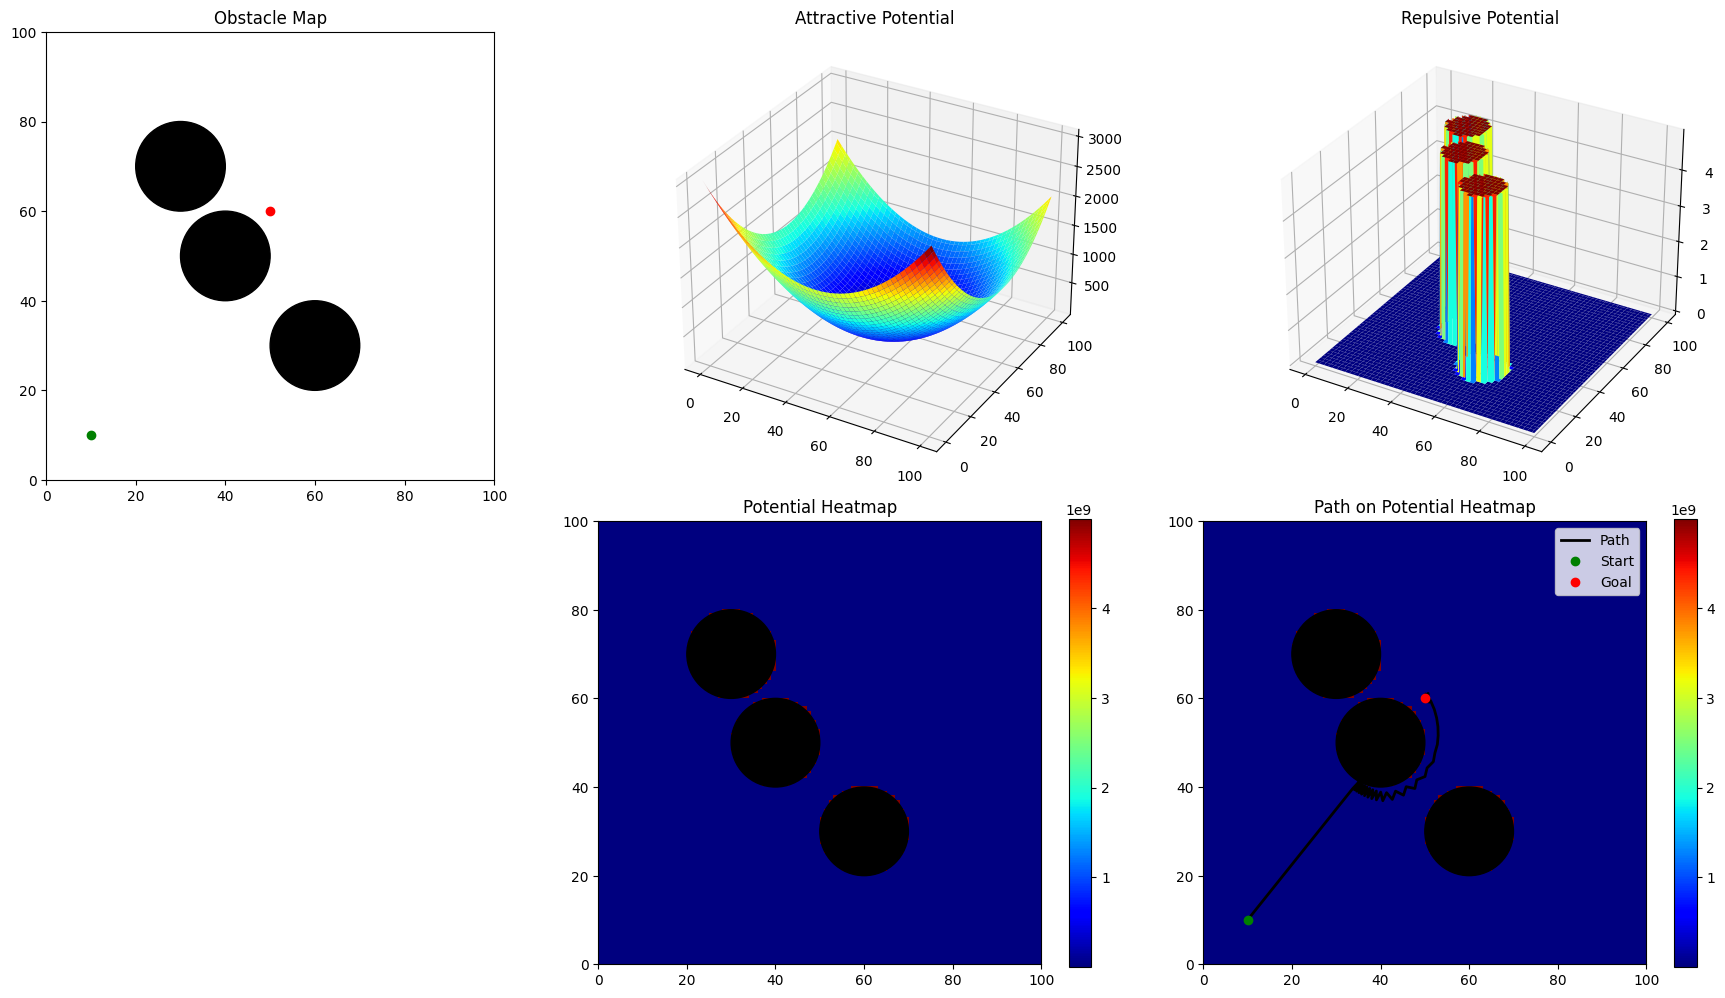

In [20]:
plot_full_potential_map(grid_size, start, goal, obstacles, path)

### Conclusion for Path Planning Using Potential Fields

Path planning using potential fields is a classic and intuitive approach for navigating agents (e.g., robots or autonomous vehicles) in environments with static obstacles. Based on simulating attractive and repulsive forces, this method allows an agent to move toward a goal while avoiding obstacles. After implementing and visualizing this technique through potential maps and gradient descent path planning, several key conclusions can be drawn:

**1. Effectiveness of Gradient Descent in Navigation**

The potential field method uses the negative gradient of a scalar potential field to guide motion:
- The goal exerts an attractive force, modeled as a parabolic well (bowl-shaped potential).
- Obstacles exert repulsive forces, modeled as sharp potential "hills" or "cylinders".

The agent starts at an initial position and follows the steepest descent of this combined field, naturally guiding it toward the goal while avoiding obstacles. Gradient-based path planning effectively creates collision-free trajectories when the environment is static and known in advance. The path tends to be smooth and efficient, and it requires no explicit path search algorithm.

**2. Parameter Sensitivity**

The performance and reliability of potential field path planning are highly sensitive to several key parameters:
- **Attractive Gain (k_att)**
  - Controls how strongly the robot is pulled toward the goal.
  - A low value results in a weak attraction and slow convergence.
  - A high value may cause overly aggressive motion that ignores obstacles.

- **Repulsive Gain (k_rep)**
    - Determines how strongly obstacles repel the robot.
    - Too high: path becomes erratic or diverges from goal.
    - Too low: robot may collide with obstacles.

- **Repulsive Threshold Distance**
    - Defines the region around obstacles that exerts a repulsive force.
    - A small threshold may fail to prevent collisions.
    - A large threshold can create unnecessary detours.

- **Obstacle Radius**
    - Used to define effective size of obstacles in the repulsive potential.
    - Affects how close the robot perceives it can safely travel near obstacles.

- **Step Size (in gradient descent)**
    - Controls how far the robot moves in the direction of the negative gradient at each iteration.
    - A small step size results in a smoother but slower path, potentially requiring more steps to reach the goal.
    - A large step size can cause the robot to overshoot or skip important gradient features, especially in narrow spaces.
    - Poorly tuned step size can also miss the attractive minimum or lead to oscillation around obstacles.
    
**3. Limitations: Local Minima**

The most significant drawback of potential fields is the risk of local minima, positions where the gradient becomes zero but which are not the goal. This causes the agent to get "stuck".
- Local minima occur when attractive and repulsive forces cancel each other.
- Narrow passages or complex obstacle layouts exacerbate this problem.

While elegant and efficient, the method lacks completeness (i.e., it doesn't guarantee a solution). It performs poorly in cluttered or complex environments without extra mechanisms to escape local minima.